# Modeling

In the previous notebook "eda.ipynb" I cleaned up the dataset, performed EDA, and feature engineering. I also explained my thought process for just about every step in that EDA/preprocessing notebook. In summary, there were several features that were sparse (the majority of the values were missing) - these were removed. There were other columns that had missing values - *however they were not missing at random*. The values that were missing were associated with houses that *did not* have a garage or a basement or neither of the two. I dealt with these missing values appropriately. In addition, I performed feature engineering - factors were selected graphically and then engineered mostly by aggregating low-sample levels/classes with similar levels/classes that had more samples; *this was done so the learning process of the models I choose are not dominated by one class*. Numerical features were selected by analysing the Spearman's correlation coefficient - those numerical features with large (enough) correlations were selecte. Spearman's correlation was used so as to not rule out nonlinear montonic relationships. Lastly, I calculated the *principal components* and determined that *eight* components were appropriate by analyzing the explained variance as a function of the number of principal components - *eight* principal components were most appropriate for the subset of features I chose.

In this notebook I perform model selection and validation. The models I chose for this competition are:
  1. **(OLS) Linear Regression**: because this model can be used as a benchmark model.
  2. **Ridge Regression**: since this is a regularized version of linear regression, this will balance the bias/variance and generally lead to a more accurate model. As a result, LASSO and Ridge tend to result in parsimonious models.
  3. **KNN**: There's actually no real reason why I chose to give this model a shot other than the fact I've relative success with it in the past.
  4. **XGBoost**: I've always had great success with a random forest, so I knew I wanted to give an ensemble method a shot. I also know from other Kagglers that XGBoost is kind of a gold standard and still often outperforms more sophisticated methods such as neural networks.
  5. **Stacked Generalization** - I had no idea how this model worked, but I knew it was popular among the competition crowd at least at one point. This gave me an excuse to develop a high-level understanding of how this model worked and to try it out. As can be seen from the results at the end of this notebook - this model dominated the other four individually.
  
## Table of Contents

1. [Package Import and Reading in the Clean Data](#intro)
2. [Model Fitting, Hyperparameter tuning, and Model Validation](#mod_fit)
3. [Model Evaluation](#mod_eval)
4. [Model Evaluation - Visualization](#mod_eval_vis)
4. [Discussion](#discuss)

<a id="intro"></a>

### Package Import and Reading In the Clean Data

Below I read in the appropriate packages/modules I'll be using for this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pipelines.ml_pipelines as pl

from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

dtypes = {'LotFrontage': 'double', 'LoArea': 'double',
          'MasVnrArea': 'double', 'BsmtFinSF1': 'double',
          'BsmtFinSF2': 'double', 'HeatingQC': 'category',
          'ExterQual': 'category', 'KitchenQual': 'category',
          'LotShape': 'category', 'OverallQual': 'category',
          'OverallCond': 'category', 'MSZoning': 'category'}
df_train = pd.read_csv('train.csv', dtype=dtypes)
df_test = pd.read_csv('test.csv', dtype=dtypes)

Below, I make lists of both the factors and covariates that I'll using in my models.

In [2]:
cat_feats_to_encode = ['MSZoning', 'OverallQual', 'NeighborhoodQuality', 'ExterQual', 'KitchenQual',
                       'BsmtQual']
num_feats_to_keep = ['LotFrontage', 'LotArea', 'YearBuilt',
 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
 'GrLivArea', 'FullBath', 'TotRmsAbvGrd',
 'Fireplaces', 'GarageYrBlt', 'GarageCars',
 'GarageArea', 'WoodDeckSF', 'EnclosedPorch']

### 4. CRISP-DM: Data Modeling

At this point I'm ready to start modeling the data.

<a id="mod_fit"></a>

### Model Fitting, Hyperparameter tuning, and Model Validation

For the next several code cells I fit all of the models. I don't plan on testing too many parameters to avoid long run-times, so I use grid search to exhaust the parameter space and perform 5-fold cross-validation to select the best hyperparameters for each model. Later in the notebook, I will compare the different models using their best hyperparameters and select the model that performs the best as my submission.

Below I fit and perform grid search for the XGBoost model varying just two of the possible hyperparameters.

### Initial Solution

Below I perform the model fitting for the first four models that I see doing reasonably well on this dataset - this is of course not an exhaustive list of models that could predict **SalePrice**, but it's four that are at the top of my list.

In [3]:
pipeline_xgbr = pl.pipeline_xgbr(num_feats_to_keep, cat_feats_to_encode)

In [4]:
xgbr_params = {'xgbr__max_depth':[5, 7, 10],
               'xgbr__n_estimators': [20, 50, 100]}
cv_xgbr = GridSearchCV(pipeline_xgbr, param_grid=xgbr_params, scoring='neg_mean_squared_error', cv=5)

In [5]:
cv_xgbr_obj = cv_xgbr.fit(df_train, df_train['LogSalePrice'])

In [6]:
cv_xgbr.best_params_

{'xgbr__max_depth': 5, 'xgbr__n_estimators': 20}

**Below is the cross-validation score for XGBoost**

In [7]:
np.sqrt(-cv_xgbr.cv_results_['mean_test_score'].mean())

0.16136018695430607

Below I fit and perform grid search for the **KNN** model varying the number of neighbors that the model will use to estimate the test sample.

In [8]:
pipeline_knn = pl.pipeline_knn(num_feats_to_keep, cat_feats_to_encode)

In [9]:
knn_params = {'knn__n_neighbors':[1, 5, 10, 15, 20, 25]}
cv_knn = GridSearchCV(pipeline_knn, param_grid=knn_params, scoring='neg_mean_squared_error', cv=5)

In [10]:
cv_knn_obj = cv_knn.fit(df_train, df_train['LogSalePrice'])

In [11]:
cv_knn.best_params_

{'knn__n_neighbors': 10}

**Below is the cross-validation score for KNN**

In [12]:
np.sqrt(-cv_knn.cv_results_['mean_test_score'].mean())

0.17375279905863764

Below I fit and perform grid search for the ridge regression model. For convenience, $\alpha$ measures the flexibility of the model. $\alpha=0$ is OLS and $\alpha=\infty$ is the null model.

In [13]:
pipeline_ridge = pl.pipeline_ridge(num_feats_to_keep, cat_feats_to_encode)

In [14]:
ridge_params = {'ridge__alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10]}
cv_ridge = GridSearchCV(pipeline_ridge, param_grid=ridge_params, scoring='neg_mean_squared_error', cv=5)

In [15]:
cv_ridge_obj = cv_ridge.fit(df_train, df_train['LogSalePrice'])

In [16]:
cv_ridge.best_params_

{'ridge__alpha': 1}

**Below is the cross-validation score for ridge regression**

In [17]:
np.sqrt(-cv_ridge.cv_results_['mean_test_score'].mean())

0.16176127395738757

Below I fit OLS. There are no hyperparameters to this model - therefore I perform 5-fold cross-validation using the cross_val_score function in order to compare this OLS with the other models at the end of this notebook.

In [18]:
pipeline_lm = pl.pipeline_lm(num_feats_to_keep, cat_feats_to_encode)

In [19]:
lm_cross_val_scores = cross_val_score(pipeline_lm, df_train, df_train['LogSalePrice'], cv=5, scoring='neg_mean_squared_error')

In [20]:
lm = pipeline_lm.fit(df_train, df_train['LogSalePrice'])

In [21]:
lm_preds = pipeline_lm.predict(df_train)

**Below is the cross-validation score for linear regression**

In [22]:
np.sqrt(-lm_cross_val_scores.mean())

0.1617230293410973

### Final Solution

Now that I've seen how the base-learner's validation scores compare, I believe I can do better. I will now fit a stacked regressor in order to improve the performance by combining two of the models in a process called "stacking".

Thus far we have only seen the cross-validation (CV) scores between the four models (KNN, ridge regression, linear regression, and XGBoost). Later in the notebook I will visualize the *both* the CV scores and the training scores for all of the models including the stacked regression using a pointplot.

Below I fit the stacking regressor using 5-fold cross validation to train the learners. I chose ridge regression and XGBoost (as my learners, not my meta-learners) for the following reasons:
  1. The ridge regression should have relatively high bias and will be more likely to underfit - make this the first learner.
  2. XGBoost should be very flexible (high variance) and more likely to overfit - make this the second learner.
  3. Use linear regression as the meta-learner since it's a relatively inflexible model (and thus less likely to overfit to the predictions of previous level learners).

Here I define my learners in my stacking layer and then lastly I define my meta-learner

In [23]:
estimators = [
    ('ridge', cv_ridge),
    ('xgbr', cv_xgbr)
]
st_reg = StackingRegressor(estimators, final_estimator= LinearRegression(), cv=5)

I now fit my stacking model

In [24]:
st_cross_val_score = cross_val_score(st_reg, df_train, df_train['LogSalePrice'], cv=5, scoring='neg_mean_squared_error')

In [25]:
st_reg_fit = st_reg.fit(df_train, df_train['LogSalePrice'])

In [26]:
cross_val_scores_st_reg = [np.sqrt(-score) for score in st_cross_val_score]
cross_val_scores_st_reg

[0.13876354363759097,
 0.16560200104127779,
 0.15096064586809724,
 0.14541254697585876,
 0.16513928908628334]

In [27]:
np.sqrt(-st_cross_val_score.mean())

0.15354755225048652

### 5. CRISP-DM: Evaluate the Results

At this point, I've fitted my model and calculated their cross-validation scores using 5-fold cross-validation and grid search. Now it's time to evaluate their performance and decide which model to use to make my submission to the competition.

<a id="mod_eval"></a>

### Model Evaluation

In the remainder of this notebook, I evaluate each model and display the results in a visualization. I will perform model evaluation based on the negative of the root-mean-squared-log-error (RMSLE) - the formula is given below (take the negative of the summation below):

$$\mathrm{RMSLE} = \sqrt{\frac{1}{n} \sum \limits_{i=1}^n(log(\hat{y}_i + 1) - log(y_i + 1))^2}$$

This is the official metric of the competition; RMSLE was chosen by Kaggle so that really expensive and really cheap houses affect the results equally.

I start by making two datafames that collect both the negated RMSLEs and predicted values for each model. Lastly, I make a pointplot comparing the RMSLE for each model.

I now save the fitted values - since these models were fit and selected using 5-fold CV, 20% of the predictions made by these models are predicted values and not fitted.

In [28]:
preds_st = st_reg.predict(df_train)
preds_ridge = cv_ridge.best_estimator_.predict(df_train)
preds_lm = pipeline_lm.predict(df_train)
preds_xgbr = cv_xgbr.best_estimator_.predict(df_train)
preds_knn = cv_knn.best_estimator_.predict(df_train)

In [29]:
results_df = pd.DataFrame({'observed':df_train['LogSalePrice'], 'predicted_st': pd.Series(preds_st),
                            'predicted_ridge':pd.Series(preds_ridge), 'predicted_lm': pd.Series(preds_lm),
                           'predicted_xgbr': pd.Series(preds_xgbr),
                           'predicted_knn': pd.Series(preds_knn)})

In [30]:
results_df.head()

,observed,predicted_st,predicted_ridge,predicted_lm,predicted_xgbr,predicted_knn
0,12.247694,12.173244,12.204668,12.204341,12.136874,12.248799
1,12.109011,12.149321,12.161739,12.162987,12.130186,12.063895
2,12.317167,12.197908,12.253971,12.253439,12.139193,12.243412
3,11.849398,12.090962,12.128811,12.130314,12.048723,12.033387
4,12.429216,12.613901,12.672194,12.673013,12.553362,12.603237


In the code cell below I make a dataframe of negated RMSLEs for the **XGBoost**, **ridge regression**, and **KNN** models. These are thrown into the dataframe first since they were created with GridSearchCV.

In [44]:
score_df = pd.DataFrame(columns=['model', 'nms_test_score', 'nms_train_score'])
cross_val_objs = [cv_xgbr, cv_ridge, cv_knn]
results_names = ['predicted_xgbr', 'predicted_ridge', 'predicted_knn']
names = ['XGBoost_Regression', 'Ridge_Regression', 'KNN_Regression']
for name, obj, rn in zip(names, cross_val_objs, results_names):
    row_to_add = pd.DataFrame({'model': [name],
                               'validation_score': [np.sqrt(-obj.cv_results_['mean_test_score'].mean())],
                               'train_score': [np.sqrt(mean_squared_error(results_df['observed'], results_df[rn]))]})
    
    score_df = pd.concat([score_df, row_to_add], axis=0)

In [45]:
score_df = pd.melt(score_df, id_vars='model', value_vars=['validation_score', 'train_score'])
score_df

,model,variable,value
0,XGBoost_Regression,validation_score,0.161360
1,Ridge_Regression,validation_score,0.161761
2,KNN_Regression,validation_score,0.173753
3,XGBoost_Regression,train_score,0.101206
4,Ridge_Regression,train_score,0.157001
5,KNN_Regression,train_score,0.144862


Below I add the **stacked generalizion** and **linear regression** RMSLEs to the dataframe as well. These did not need hyperparameter tuning via grid search. The RMSLE for the linear regression was estimated using 5-fold CV (earlier in the notebook) and the learners and meta-learner have already been fit to different folds of the model and the whole model respectively.

In [46]:
st_lm_score_df = pd.melt(pd.DataFrame({'model': ['Stacked_Regression', 'Linear_Regression'], 'validation_score': [np.sqrt(-st_cross_val_score.mean()), np.sqrt(-lm_cross_val_scores.mean())],
              'train_score': [np.sqrt(mean_squared_error(results_df['observed'], results_df['predicted_st'])),
                                  np.sqrt(mean_squared_error(results_df['observed'], results_df['predicted_lm']))]}),
        id_vars='model')

In [47]:
score_df = pd.concat([score_df, st_lm_score_df])

In [48]:
score_df

,model,variable,value
0,XGBoost_Regression,validation_score,0.161360
1,Ridge_Regression,validation_score,0.161761
2,KNN_Regression,validation_score,0.173753
3,XGBoost_Regression,train_score,0.101206
4,Ridge_Regression,train_score,0.157001
5,KNN_Regression,train_score,0.144862
0,Stacked_Regression,validation_score,0.153548
1,Linear_Regression,validation_score,0.161723
2,Stacked_Regression,train_score,0.120021
3,Linear_Regression,train_score,0.156998


In [49]:
score_df_wide = score_df.pivot(index=['model'], columns=['variable'], values=['value']).reset_index(level=0, col_level=1).droplevel(level=0, axis=1)
score_df_wide = score_df_wide.sort_values(by='validation_score', ascending=False)
score_df_wide['model']

0        KNN_Regression
2      Ridge_Regression
1     Linear_Regression
4    XGBoost_Regression
3    Stacked_Regression
Name: model, dtype: object

### Model Evaluation - Visualization

Below is a pointplot of the model name versus the negated RMSLE. Since the RMSLE was negated it is now a score (bigger is better). From the pointplot below, we can see that the stacked regressor outperforms all of the other models by almost 2-fold (and the stacked regressor outperforms **KNN** by more than this). **XGBoost**, **linear regression**, and **ridge regression** perform similarly and the model with the worst performance is **KNN**.

From this visualization I can conclude that the stacked generalization is the most highly performant model - I will use my stacked regression model for my competition submission.

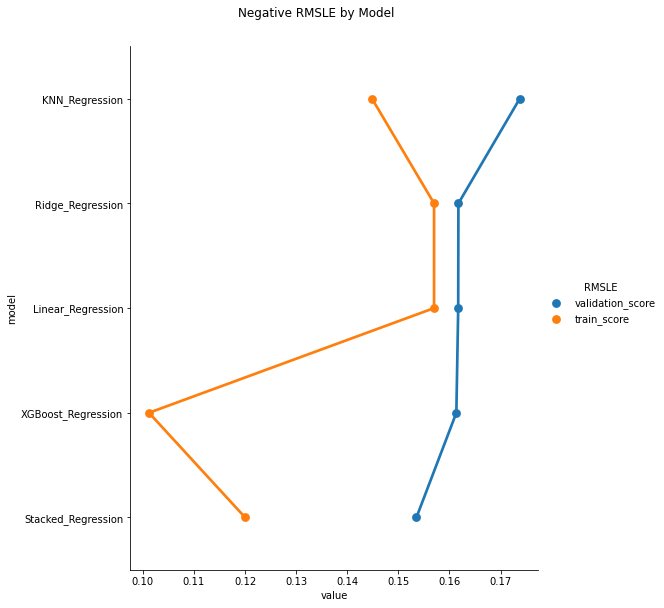

In [50]:
g = sns.catplot(x='value', y='model', data=score_df, hue='variable', height=8, aspect=1, dodge=False,
            s=15, kind='point', order=score_df_wide['model'], facet_kws={'legend_out': True});
g.fig.suptitle('Negative RMSLE by Model', y=1.05)
g._legend.set_title('RMSLE')

In [38]:
score_df['dataset'] = 'test'
score_df

,model,variable,value,dataset
0,XGBoost_Regression,validation_score,0.161360,test
1,Ridge_Regression,validation_score,0.161761,test
2,KNN_Regression,validation_score,0.173753,test
3,XGBoost_Regression,train_score,0.101206,test
4,Ridge_Regression,train_score,0.157001,test
5,KNN_Regression,train_score,0.144862,test
0,Stacked_Regression,validation_score,0.153548,test
1,Linear_Regression,validation_score,0.161723,test
2,Stacked_Regression,train_score,0.120021,test
3,Linear_Regression,train_score,0.156998,test


<a id="mod_eval_vis"></a>

### 6. CRISP-DM: Deploy

The remainder of this notebook constructs a CSV of my submission for the Kaggle house prices competition.

In [39]:
ids = pd.DataFrame(df_test['Id'], columns=['Id'])
ids

,Id
0,1461
1,1462
2,1463
3,1464
4,1465
...,...
1454,2915
1455,2916
1456,2917
1457,2918


In [40]:
predictions = pd.DataFrame(np.exp(st_reg.predict(df_test)), columns=['SalePrice'])

In [41]:
submission = pd.concat([ids, predictions], axis=1)

In [42]:
submission.to_csv('submission.csv', index=False)

In [43]:
pd.read_csv('submission.csv')

,Id,SalePrice
0,1461,116674.153999
1,1462,152857.348517
2,1463,190613.331017
3,1464,212016.084356
4,1465,187303.500554
...,...,...
1454,2915,82063.690461
1455,2916,89514.058363
1456,2917,196027.033824
1457,2918,129013.645770


<a id="discuss"></a>

## Discussion

In this notebook I accomplished a lot - model selection and validation. I evaluated each base model, namely **KNN**, **linear regression**, **ridge regression**, and **XGBoost** separately using 5-fold CV. I then decided to see how a **stacked regression** would perform by combining a reltively inflexible model (**ridge regression**) and a highly flexible model (**XGBoost**) as my stacked learners and I then used OLS as my meta-learner.

The stacked regression clearly had the highest performance of all the models and I therefore used this model for my submission to the competition. I fully expected to come in about dead-last in the competition, but I did a lot better than I thought - I came in **2491/4325** place at the time of my submission. This was really fun and I see myself being a regular in these competitions to simply just to push myself to learn more about predictive modeling.

Now to discuss the best fit hyperparameters of the base-learners that were used in the **stacked regression**. The best $\alpha$ value for the **ridge regression** was $\alpha=1$. This particular parameter would have made the second-most inflexible regression model (remember, larger values of $\alpha$ mean a more biased/inflexible regression model. In addition, the best performing **XGBoost** hyperparmeters were 5 for the maximum depth of a tree and 20 trees - this pair of hyperparameters makes the least complex ensemble of learners. The answer I believe is in the EDA notebook, specifically where I plot the boxplots versus **LogSalePrice** and also where I plot the first *eight* principal components versus **LogSalePrice**. If you first refer to the boxplots of many of the ordered factors you can see that there is what looks like a linearly increasing relationship for higher-order levels. If you now refer to the end of the EDA notebook where I plot the first principal componet versus **LogSalePrice** you can see that there is a strong *linear* relationship. I believe that the relationship between **LogSalePrice** and the features I predicted is close to linear and therefore nonlinear approaches might overfit which is why you see a trend of hyperparameters that will yield less flexlible/linear-like models.

Now, embarassingly, I only decided to look at the plots of the principal components versus **LogSalePrice** **after** I had performed model selection and validation. To my dismay I can really only see a visible relationship between the first principal component and **LogSalePrice** - this is just a consequence of PCA being unsupervised. If I could rewind time I would first see how my model performs on the raw numerical features *and then* see how the princpal components affects model performance - this is the last time I get burned by PCA. I believe that using *only* the raw numerical features in my model will significantly improve its performance. In addition, I would try to improve model performance by performing *more* feature engineering. I believe that calculating more domain specific features would greatly improve the model. Lastly, I also believe that creating meta-features will improve model performance as well. I would calculate things like the mean and standard deviation of each row of the numerical feature model matrix to see how that affects model performance.

I found the open-endedness the most difficult and most exciting part of this project. Many academic datasets found at universities and certificate programs have small numbers of predictors/features (< 20). This dataset had a moderate amount (79 to be exact) and it was at first overwhelming, but as you begin to find patterns and uncover relationships it becomes a pleasure to reiterate the different key-points within the CRISP-DM process (EDA for example within the **prepare the data** step or tuning the hyperparameters in the **data modeling** step). I will be continuing this project to climb higher in the rankings after I submit it in its current state for my data scientist capstone. I've already mentioned a couple of ways to improve the performance of my model and I believe I could climb significantly higher in the rankings by implementing these improvements.

A nice summary of the end-to-end solution can be found in the README.md accompanying the respository that this notebook is located within.

In the end, I am satisfied by my performance in my first machine learning competition and I must say I am hooked. I'm already planning my next beginner competition at Kaggle (the infamous Titanic competition) to learn more and isn't that the whole point?